## <font color='cornflowerblue'> Packages

In [1]:
import ta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

## <font color='cornflowerblue'> Classes and Functions

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

In [3]:
class TradingMetrics:
    def __init__(self, portfolio_values: list[float], time_frame: int):
        self.portfolio_values = portfolio_values
        self.time_frame = time_frame  # in minutes

        self.df = pd.DataFrame({
            'value': self.portfolio_values,
            'rets': pd.Series(self.portfolio_values).pct_change()
        }).dropna()

    def sharpe_ratio(self) -> float:
        mean = self.df.rets.mean()
        std = self.df.rets.std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_std = std * np.sqrt(bars_per_year)
        
        return annual_mean / annual_std if annual_std != 0 else 0.0

    def sortino_ratio(self) -> float:
        mean = self.df.rets.mean()
        downside_risk = np.minimum(self.df.rets, 0).std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_downside_risk = downside_risk * np.sqrt(bars_per_year)

        return annual_mean / annual_downside_risk if annual_downside_risk != 0 else 0.0

    def max_drawdown(self) -> float:
        roll_max = self.df.value.cummax()
        drawdown = (roll_max - self.df.value) / roll_max  # Drawdown as positive values
        return drawdown.max()  # Maximum drawdown as positive percentage

    def calmar_ratio(self) -> float:
        mean = self.df.rets.mean()
        
        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        
        max_dd = self.max_drawdown()  # Now this returns a positive value
        
        return annual_mean / max_dd if max_dd != 0 else 0.0

    def show_metrics(self) -> pd.DataFrame:
        df = pd.DataFrame(
            {
                'Metric': ['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio'],
                'Value': [self.sharpe_ratio(), self.sortino_ratio(), f'{self.max_drawdown():.2%}', self.calmar_ratio()]
            }
        )
        return df

In [4]:
def rsi(data: pd.DataFrame, window: int, rsi_lower: int, rsi_upper: int) -> pd.DataFrame:
    df = data.copy()
    rsi_indicator = ta.momentum.RSIIndicator(df.Close, window=window)
    df['rsi'] = rsi_indicator.rsi()
    df['buy_signal'] = df['rsi'] < rsi_lower
    df['sell_signal'] = df['rsi'] > rsi_upper
    df = df.dropna()
    return df

In [5]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float) -> float:
    
    val = cash 

    # Longs
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Shorts
    short_val = sum(
        (pos.price - current_price) * pos.n_shares * (1 - COM)
        for pos in short_ops
    )

    return val + short_val

## <font color='cornflowerblue'> Data

In [6]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.758580e+12,22/09/25 23:00,BTCUSDT,112643.25,112739.14,112592.20,112650.99,135.310950,1.524494e+07,34083
1,1.758580e+12,22/09/25 22:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836
2,1.758570e+12,22/09/25 21:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
3,1.758570e+12,22/09/25 20:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
4,1.758570e+12,22/09/25 19:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
...,...,...,...,...,...,...,...,...,...,...
70822,1.502960e+12,17/08/17 8:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
70823,1.502950e+12,17/08/17 7:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
70824,1.502950e+12,17/08/17 6:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
70825,1.502950e+12,17/08/17 5:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102


In [7]:
# Find columns containing "Date"
date_cols = [col for col in data.columns if "Date" in col]

# Rename them to "Datetime"
for col in date_cols:
    data = data.rename(columns={col: "Datetime"})

data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)

if data.Datetime.iloc[0] > data.Datetime.iloc[-1]:
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)

/var/folders/60/rl4yk8jj3453bx7hbt074rbc0000gn/T/ipykernel_19521/584127041.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)


In [8]:
data

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
70822,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
70823,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
70824,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
70825,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836


In [9]:
train_size = int(len(data) * 0.6)
test_size = int(len(data) * 0.2)

In [10]:
train = data[:train_size]
test = data[train_size:train_size + test_size]
validation = data[train_size + test_size:]

In [11]:
#data = pd.read_csv('aapl_5m_train.csv').dropna()

In [12]:
#data = rsi(data, window=25, rsi_lower=32, rsi_upper=72)
#data.head()

## <font color='cornflowerblue'> Parameters

In [13]:
COM: float = 0.125 / 100
BORROW_RATE: float = 0.25 / 100
INITIAL_MARGIN = 1.5
MAINTENANCE_MARGIN = 0.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = BORROW_RATE / bars_per_year

# DOF
STOP_LOSS: float = 0.1
TAKE_PROFIT: float = 0.1
N_SHARES: int = 50

## <font color='cornflowerblue'> Backtest

In [14]:
capital: float = 1_000_000

portfolio_value = [capital]
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in data.iterrows():
    # Checkin nonnegative portfolio value
    if portfolio_value[-1] < 0:
        print("Portfolio value went negative. Stopping backtest.")
        portfolio_value.extend([0] * (len(data)-len(portfolio_value)))
        break
    
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    # -- SHORT -- #
    # Check active orders
    for position in active_short_positions.copy():
        # Stop loss or take profit check
        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
            capital += pnl
            # Remove position from active position
            active_short_positions.remove(position)
            continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           time=row.Datetime)
            active_long_positions.append(pos)

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        commission = row.Close * N_SHARES * COM
        # Do we have enough cash?
        if capital > commission:
            # Discount commission
            capital -= commission
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                            sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                            time=row.Datetime)
            active_short_positions.append(pos)

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM))

# At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

for position in active_short_positions:
    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
    capital += pnl

active_long_positions = []
active_short_positions = []

In [15]:
capital

1000000.0

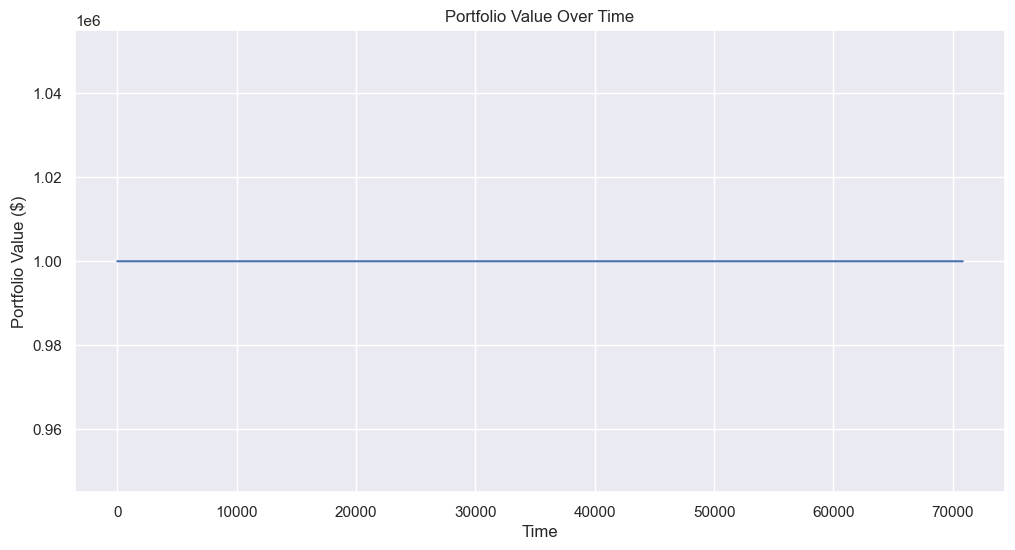

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.show()

## <font color='cornflowerblue'> Metrics

In [17]:
metrics = TradingMetrics(portfolio_value, time_frame=5)
metrics.show_metrics()

,Metric,Value
0,Sharpe Ratio,0.0
1,Sortino Ratio,0.0
2,Max Drawdown,0.00%
3,Calmar Ratio,0.0


In [18]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=15)
data['rsi'] = rsi_indicator.rsi()

In [19]:
sma_low = ta.trend.SMAIndicator(data.Close, window=50)
data['sma_low'] = sma_low.sma_indicator()

smi_high = ta.trend.SMAIndicator(data.Close, window=200)
data['sma_high'] = smi_high.sma_indicator()

In [20]:
macd_indicator = ta.trend.MACD(
    close=data.Close,
    window_slow=26,  # standard slow EMA
    window_fast=12,  # standard fast EMA
    window_sign=9    # signal line EMA
)

data['macd'] = macd_indicator.macd()
data['macd_signal'] = macd_indicator.macd_signal()
data['macd_diff'] = macd_indicator.macd_diff()

In [21]:
data['rsi_buy_signal'] = data['rsi'] < 20
data['rsi_sell_signal'] = data['rsi'] > 80

data['sma_buy_signal'] = ((data['sma_low'] > data['sma_high']) & (data['sma_low'].shift(1) <= data['sma_high'].shift(1)))
data['sma_sell_signal'] = ((data['sma_low'] < data['sma_high']) & (data['sma_low'].shift(1) >= data['sma_high'].shift(1)))

data['macd_buy_signal'] = ((data['macd'] > data['macd_signal']) & (data['macd'].shift(1) <= data['macd_signal'].shift(1)))
data['macd_sell_signal'] = ((data['macd'] < data['macd_signal']) & (data['macd'].shift(1) >= data['macd_signal'].shift(1)))

data.head()

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,...,sma_high,macd,macd_signal,macd_diff,rsi_buy_signal,rsi_sell_signal,sma_buy_signal,sma_sell_signal,macd_buy_signal,macd_sell_signal
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,202366.138400,171,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,100304.823600,102,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,31282.312670,36,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,19241.058300,25,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4239.503586,28,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False


In [22]:
data['buy_signal'] = (data[['rsi_buy_signal', 'sma_buy_signal', 'macd_buy_signal']].sum(axis=1) >= 2)
data['sell_signal'] = (data[['rsi_sell_signal', 'sma_sell_signal', 'macd_sell_signal']].sum(axis=1) >= 2)

In [23]:
data.buy_signal.sum()
data.sell_signal.sum()

14